In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10, STL10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from fastai.vision.models.unet import DynamicUnet
import torch.optim as optim
from skimage.color import lab2rgb, rgb2lab
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


Train generators using backprop

In [ ]:
def train_generator(model, dataloader, optimizer, criterion, num_epochs=40):
    model.train()
    all_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=True)

        for l_batch, ab_batch in loop:
            l_batch = l_batch.to(device)
            ab_batch = ab_batch.to(device)

            optimizer.zero_grad()
            preds = model(l_batch)
            loss = criterion(preds, ab_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_loss = running_loss / len(dataloader)
        all_losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Avg Loss = {avg_loss:.4f}")

    return all_losses

## CIFAR10 (32x32)

Import dataset

In [ ]:
class CIFAR10ColorizationDataset(Dataset):
    def __init__(self, train=True):
        cifar_dataset = CIFAR10(root='./data', train=train, download=True, transform=transforms.ToTensor())

        self.data = []
        for img, _ in cifar_dataset:
            img_np = img.permute(1, 2, 0).numpy()

            # Convert to LAB
            lab = rgb2lab(img_np).astype(np.float32)

            L = (lab[:, :, 0:1] / 50.0 - 1.0)
            ab = lab[:, :, 1:] / 110.0

            # Convert to tensors (C, H, W)
            lab_tensor = torch.from_numpy(np.concatenate([L, ab], axis=-1)).permute(2, 0, 1).float()
            l_tensor = lab_tensor[[0], ...]  # Shape: (1, H, W)
            ab_tensor = lab_tensor[1:, ...]  # Shape: (2, H, W)

            self.data.append((l_tensor, ab_tensor))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Load datasets
full_train_dataset = CIFAR10ColorizationDataset(train=True)
test_dataset = CIFAR10ColorizationDataset(train=False)

# Subset first 8000 for training
subset_size = 8000
dataset = torch.utils.data.Subset(full_train_dataset, range(subset_size))

dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, prefetch_factor=2, pin_memory=True)

Import **pretrained CIFAR10 encoder**, modify input to take L channel, then attach decoder to transform into U-Net

In [ ]:
body = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
body = nn.Sequential(*list(body.children())[:-2]) # Remove classification layers
body[0] = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)

net_G = DynamicUnet(body, n_out=2, img_size=(32, 32))

net_G = net_G.to(device)

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 33.2MB/s

In [ ]:
criterion = nn.L1Loss() # Use L1 loss to minimize color differences
opt = optim.Adam(net_G.parameters(), lr=1e-4)

losses_cifar10_unet = train_generator(net_G, dataloader, opt, criterion, num_epochs=50)
torch.save(net_G.state_dict(), "cifar10-unet.pt")

Epoch [1/50]: 100%|██████████| 500/500 [00:10<00:00, 47.45it/s, loss=0.0514]


Epoch 1: Avg Loss = 0.0571


Epoch [2/50]: 100%|██████████| 500/500 [00:10<00:00, 47.50it/s, loss=0.0552]


Epoch 2: Avg Loss = 0.0568


Epoch [3/50]: 100%|██████████| 500/500 [00:10<00:00, 48.92it/s, loss=0.0595]


Epoch 3: Avg Loss = 0.0563


Epoch [4/50]: 100%|██████████| 500/500 [00:10<00:00, 48.13it/s, loss=0.0587]


Epoch 4: Avg Loss = 0.0559


Epoch [5/50]: 100%|██████████| 500/500 [00:10<00:00, 45.58it/s, loss=0.0607]


Epoch 5: Avg Loss = 0.0558


Epoch [6/50]: 100%|██████████| 500/500 [00:10<00:00, 49.23it/s, loss=0.0572]


Epoch 6: Avg Loss = 0.0553


Epoch [7/50]: 100%|██████████| 500/500 [00:09<00:00, 50.31it/s, loss=0.0636]


Epoch 7: Avg Loss = 0.0547


Epoch [8/50]: 100%|██████████| 500/500 [00:09<00:00, 51.26it/s, loss=0.0591]


Epoch 8: Avg Loss = 0.0544


Epoch [9/50]: 100%|██████████| 500/500 [00:10<00:00, 48.38it/s, loss=0.0515]


Epoch 9: Avg Loss = 0.0540


Epoch [10/50]: 100%|██████████| 500/500 [00:10<00:00, 47.21it/s, loss=0.0603]


Epoch 10: Avg Loss = 0.0537


Epoch [11/50]: 100%|██████████| 500/500 [00:10<00:00, 47.46it/s, loss=0.0506]


Epoch 11: Avg Loss = 0.0535


Epoch [12/50]: 100%|██████████| 500/500 [00:10<00:00, 46.40it/s, loss=0.0499]


Epoch 12: Avg Loss = 0.0529


Epoch [13/50]: 100%|██████████| 500/500 [00:10<00:00, 46.25it/s, loss=0.0721]


Epoch 13: Avg Loss = 0.0528


Epoch [14/50]: 100%|██████████| 500/500 [00:09<00:00, 50.72it/s, loss=0.0462]


Epoch 14: Avg Loss = 0.0521


Epoch [15/50]: 100%|██████████| 500/500 [00:10<00:00, 48.71it/s, loss=0.0514]


Epoch 15: Avg Loss = 0.0519


Epoch [16/50]: 100%|██████████| 500/500 [00:10<00:00, 48.15it/s, loss=0.0568]


Epoch 16: Avg Loss = 0.0516


Epoch [17/50]: 100%|██████████| 500/500 [00:10<00:00, 47.99it/s, loss=0.0501]


Epoch 17: Avg Loss = 0.0512


Epoch [18/50]: 100%|██████████| 500/500 [00:10<00:00, 48.61it/s, loss=0.0544]


Epoch 18: Avg Loss = 0.0509


Epoch [19/50]: 100%|██████████| 500/500 [00:10<00:00, 48.19it/s, loss=0.0491]


Epoch 19: Avg Loss = 0.0505


Epoch [20/50]: 100%|██████████| 500/500 [00:09<00:00, 51.62it/s, loss=0.0487]


Epoch 20: Avg Loss = 0.0501


Epoch [21/50]: 100%|██████████| 500/500 [00:10<00:00, 49.00it/s, loss=0.0408]


Epoch 21: Avg Loss = 0.0501


Epoch [22/50]: 100%|██████████| 500/500 [00:10<00:00, 48.35it/s, loss=0.0505]


Epoch 22: Avg Loss = 0.0497


Epoch [23/50]: 100%|██████████| 500/500 [00:10<00:00, 45.59it/s, loss=0.0504]


Epoch 23: Avg Loss = 0.0496


Epoch [24/50]: 100%|██████████| 500/500 [00:10<00:00, 47.16it/s, loss=0.0455]


Epoch 24: Avg Loss = 0.0493


Epoch [25/50]: 100%|██████████| 500/500 [00:10<00:00, 46.22it/s, loss=0.0604]


Epoch 25: Avg Loss = 0.0489


Epoch [26/50]: 100%|██████████| 500/500 [00:10<00:00, 46.82it/s, loss=0.0478]


Epoch 26: Avg Loss = 0.0486


Epoch [27/50]: 100%|██████████| 500/500 [00:10<00:00, 48.46it/s, loss=0.0462]


Epoch 27: Avg Loss = 0.0485


Epoch [28/50]: 100%|██████████| 500/500 [00:10<00:00, 47.07it/s, loss=0.0543]


Epoch 28: Avg Loss = 0.0482


Epoch [29/50]: 100%|██████████| 500/500 [00:10<00:00, 46.21it/s, loss=0.0469]


Epoch 29: Avg Loss = 0.0479


Epoch [30/50]: 100%|██████████| 500/500 [00:10<00:00, 46.84it/s, loss=0.046]


Epoch 30: Avg Loss = 0.0477


Epoch [31/50]: 100%|██████████| 500/500 [00:10<00:00, 47.38it/s, loss=0.0481]


Epoch 31: Avg Loss = 0.0475


Epoch [32/50]: 100%|██████████| 500/500 [00:10<00:00, 48.13it/s, loss=0.0416]


Epoch 32: Avg Loss = 0.0472


Epoch [33/50]: 100%|██████████| 500/500 [00:10<00:00, 49.42it/s, loss=0.0517]


Epoch 33: Avg Loss = 0.0469


Epoch [34/50]: 100%|██████████| 500/500 [00:10<00:00, 49.69it/s, loss=0.051]


Epoch 34: Avg Loss = 0.0469


Epoch [35/50]: 100%|██████████| 500/500 [00:10<00:00, 47.11it/s, loss=0.047]


Epoch 35: Avg Loss = 0.0466


Epoch [36/50]: 100%|██████████| 500/500 [00:10<00:00, 48.34it/s, loss=0.057]


Epoch 36: Avg Loss = 0.0465


Epoch [37/50]: 100%|██████████| 500/500 [00:10<00:00, 48.30it/s, loss=0.0472]


Epoch 37: Avg Loss = 0.0462


Epoch [38/50]: 100%|██████████| 500/500 [00:10<00:00, 48.53it/s, loss=0.0519]


Epoch 38: Avg Loss = 0.0460


Epoch [39/50]: 100%|██████████| 500/500 [00:09<00:00, 50.74it/s, loss=0.051]


Epoch 39: Avg Loss = 0.0459


Epoch [40/50]: 100%|██████████| 500/500 [00:10<00:00, 49.01it/s, loss=0.0431]


Epoch 40: Avg Loss = 0.0455


Epoch [41/50]: 100%|██████████| 500/500 [00:10<00:00, 47.55it/s, loss=0.0396]


Epoch 41: Avg Loss = 0.0453


Epoch [42/50]: 100%|██████████| 500/500 [00:10<00:00, 47.21it/s, loss=0.0561]


Epoch 42: Avg Loss = 0.0453


Epoch [43/50]: 100%|██████████| 500/500 [00:10<00:00, 47.93it/s, loss=0.0406]


Epoch 43: Avg Loss = 0.0449


Epoch [44/50]: 100%|██████████| 500/500 [00:10<00:00, 48.69it/s, loss=0.0466]


Epoch 44: Avg Loss = 0.0448


Epoch [45/50]: 100%|██████████| 500/500 [00:09<00:00, 50.81it/s, loss=0.0473]


Epoch 45: Avg Loss = 0.0446


Epoch [46/50]: 100%|██████████| 500/500 [00:10<00:00, 45.55it/s, loss=0.0418]


Epoch 46: Avg Loss = 0.0442


Epoch [47/50]: 100%|██████████| 500/500 [00:13<00:00, 36.05it/s, loss=0.0453]


Epoch 47: Avg Loss = 0.0444


Epoch [48/50]: 100%|██████████| 500/500 [00:13<00:00, 37.96it/s, loss=0.0419]


Epoch 48: Avg Loss = 0.0441


Epoch [49/50]: 100%|██████████| 500/500 [00:13<00:00, 36.67it/s, loss=0.0442]


Epoch 49: Avg Loss = 0.0439


Epoch [50/50]: 100%|██████████| 500/500 [00:09<00:00, 52.19it/s, loss=0.0635]


Epoch 50: Avg Loss = 0.0439


Visualize

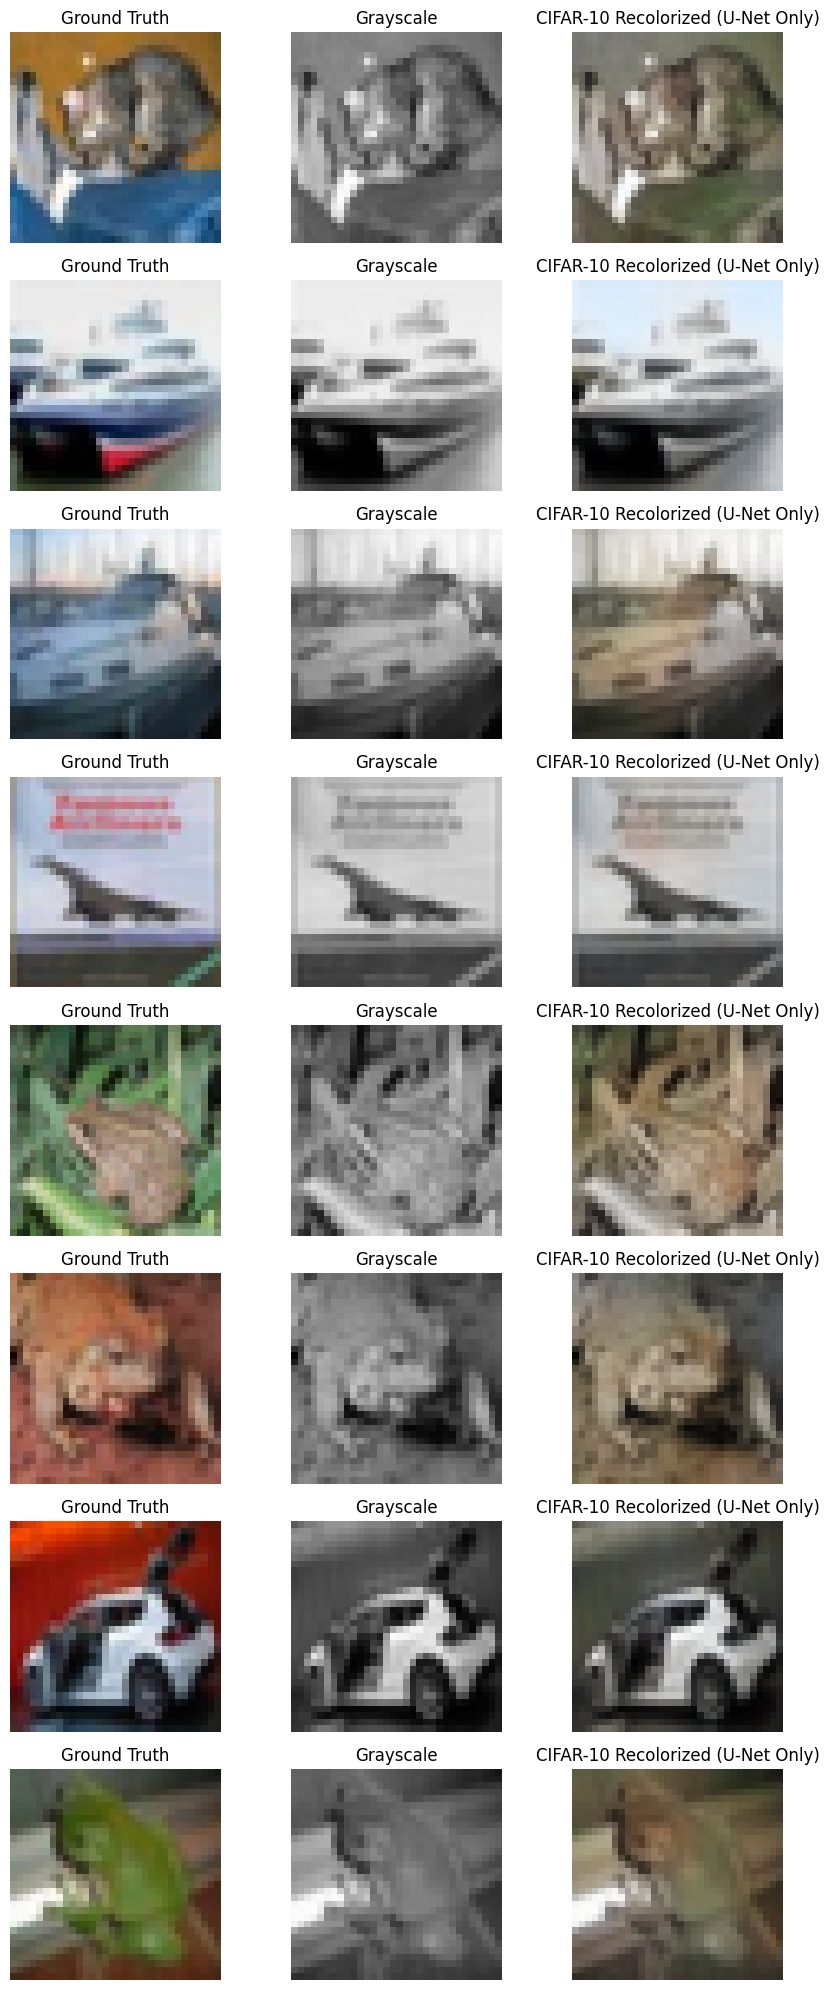

In [ ]:
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

def lab_to_rgb(L_tensor, ab_tensor):
    # Undo normalization
    L = (L_tensor.squeeze(0).cpu().numpy() + 1.0) * 50.0  # L in [0, 100]
    ab = (ab_tensor.cpu().numpy() * 110.0)                # ab in [-128, 127]

    # Recombine LAB image
    lab = np.concatenate([L[np.newaxis, :, :], ab], axis=0).transpose(1, 2, 0)  # (H, W, 3)

    rgb = lab2rgb(lab)

    rgb_uint8 = (rgb * 255).astype(np.uint8)
    return rgb_uint8

def l_to_gray_rgb(L_tensor):
    L_unscaled = (L_tensor.squeeze(0).cpu().numpy() + 1.0) * 50.0
    gray_normalized = L_unscaled / 100.0
    gray_uint8 = (gray_normalized * 255).astype(np.uint8)
    gray_rgb = cv2.cvtColor(gray_uint8, cv2.COLOR_GRAY2RGB)
    return gray_rgb

n = 8
fig, axs = plt.subplots(n, 3, figsize=(9, 2.5 * n))

for i in range(n):
    L, ab_gt = test_dataset[i]
    L_input = L.unsqueeze(0).to(device)

    with torch.no_grad():
        ab_pred = net_G(L_input).squeeze(0).cpu()

    ab_pred = torch.clamp(ab_pred, -1.0, 1.0)

    gt_rgb = lab_to_rgb(L, ab_gt)
    pred_rgb = lab_to_rgb(L, ab_pred)
    gray_rgb = l_to_gray_rgb(L)

    axs[i, 0].imshow(gt_rgb)
    axs[i, 0].set_title("Ground Truth")

    axs[i, 1].imshow(gray_rgb)
    axs[i, 1].set_title("Grayscale")

    axs[i, 2].imshow(pred_rgb)
    axs[i, 2].set_title("CIFAR-10 Recolorized (U-Net Only)")

    for j in range(3):
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()


PatchDiscriminator for GAN

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c=3, num_filters=64, n_down=2):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, k=4, s=2, p=1, norm=False)]
        model += [self.get_layers(num_filters, num_filters * 2, k=4, s=2, p=1)]  # 64 -> 128
        model += [self.get_layers(num_filters * 2, 1, k=4, s=1, p=1, norm=False, act=False)]  # 128 -> 1
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, inplace=True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [ ]:
G = net_G
D = PatchDiscriminator(input_c=3).to(device)

Train with GAN

In [ ]:
num_epochs = 40

opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

criterion_GAN = nn.BCEWithLogitsLoss() # Use Binary Cross-Entropy loss for discriminator (classifying)
criterion_L1 = nn.L1Loss() # Use L1 loss again for generator
lambda_L1 = 100

for epoch in range(num_epochs):
    for L, ab in dataloader:
        L, ab = L.to(device), ab.to(device)
        real_input = torch.cat([L, ab], dim=1)

        # 1. Train Discriminator
        with torch.no_grad():
            fake_ab = G(L)
        fake_input = torch.cat([L, fake_ab], dim=1)

        D_real = D(real_input)
        D_fake = D(fake_input)

        valid = torch.ones_like(D_real)
        fake = torch.zeros_like(D_fake)

        loss_D = 0.5 * (criterion_GAN(D_real, valid) + criterion_GAN(D_fake, fake))

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # 2. Train Generator
        fake_ab = G(L)
        fake_input = torch.cat([L, fake_ab], dim=1)
        D_fake_for_G = D(fake_input)

        loss_G_GAN = criterion_GAN(D_fake_for_G, valid)
        loss_G_L1 = criterion_L1(fake_ab, ab)
        loss_G = loss_G_GAN + lambda_L1 * loss_G_L1

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    if (epoch + 1) % 20 == 0:
      torch.save(G.state_dict(), f"G_epoch{epoch+1}_cifar10_gan.pt")

    print(f"Epoch {epoch+1}: D = {loss_D.item():.3f}, G = {loss_G.item():.3f}, L1 = {loss_G_L1.item():.3f}")


Epoch 1: D = 0.599, G = 6.703, L1 = 0.054
Epoch 2: D = 0.588, G = 5.933, L1 = 0.049
Epoch 3: D = 0.552, G = 6.846, L1 = 0.060
Epoch 4: D = 0.619, G = 5.907, L1 = 0.051
Epoch 5: D = 0.537, G = 5.983, L1 = 0.050
Epoch 6: D = 0.752, G = 5.527, L1 = 0.046
Epoch 7: D = 0.646, G = 5.932, L1 = 0.051
Epoch 8: D = 0.563, G = 6.110, L1 = 0.051
Epoch 9: D = 0.400, G = 6.762, L1 = 0.057
Epoch 10: D = 0.565, G = 6.442, L1 = 0.057
Epoch 11: D = 0.517, G = 6.935, L1 = 0.060
Epoch 12: D = 0.491, G = 6.714, L1 = 0.055
Epoch 13: D = 0.558, G = 5.920, L1 = 0.050
Epoch 14: D = 0.572, G = 6.416, L1 = 0.055
Epoch 15: D = 0.667, G = 6.174, L1 = 0.054
Epoch 16: D = 0.652, G = 6.634, L1 = 0.059
Epoch 17: D = 0.646, G = 5.304, L1 = 0.044
Epoch 18: D = 0.546, G = 6.296, L1 = 0.053
Epoch 19: D = 0.541, G = 5.809, L1 = 0.049
Epoch 20: D = 0.513, G = 6.850, L1 = 0.061
Epoch 21: D = 0.586, G = 6.005, L1 = 0.053
Epoch 22: D = 0.712, G = 5.591, L1 = 0.045
Epoch 23: D = 0.580, G = 5.818, L1 = 0.051
Epoch 24: D = 0.615,

Visualize

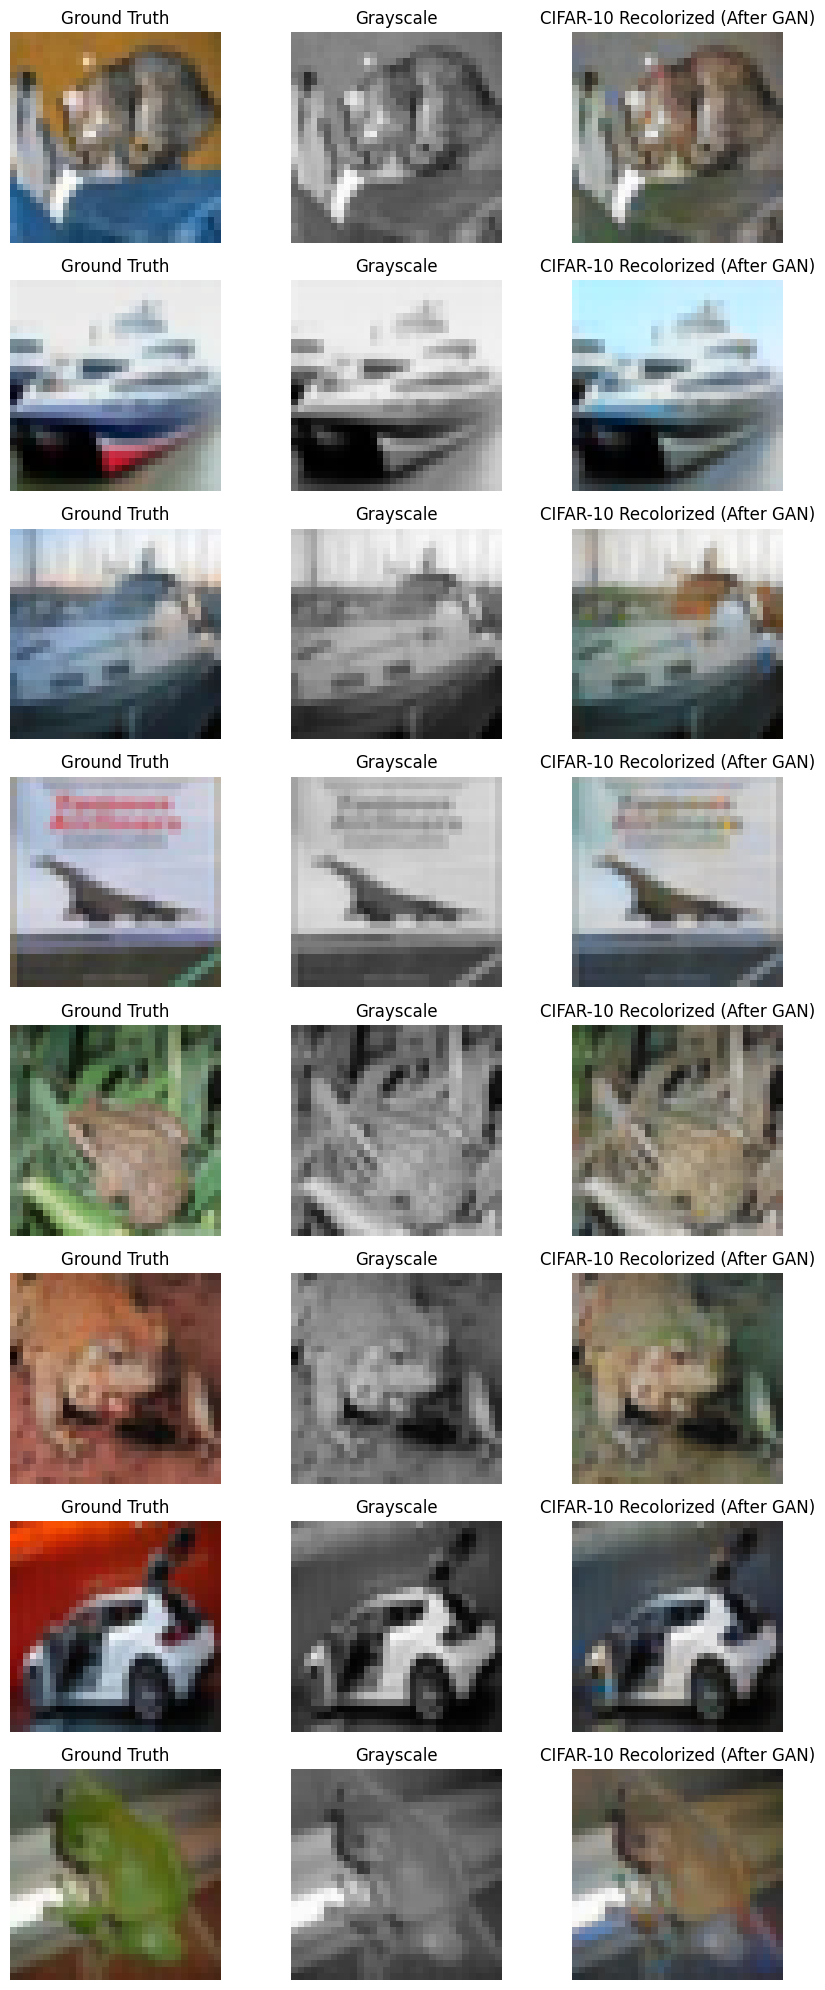

In [ ]:
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

def lab_to_rgb(L_tensor, ab_tensor):
    L = (L_tensor.squeeze(0).cpu().numpy() + 1.0) * 50.0
    ab = (ab_tensor.cpu().numpy() * 110.0)

    lab = np.concatenate([L[np.newaxis, :, :], ab], axis=0).transpose(1, 2, 0)  # (H, W, 3)

    rgb = lab2rgb(lab)

    rgb_uint8 = (rgb * 255).astype(np.uint8)
    return rgb_uint8

def l_to_gray_rgb(L_tensor):
    L_unscaled = (L_tensor.squeeze(0).cpu().numpy() + 1.0) * 50.0
    gray_normalized = L_unscaled / 100.0
    gray_uint8 = (gray_normalized * 255).astype(np.uint8)
    gray_rgb = cv2.cvtColor(gray_uint8, cv2.COLOR_GRAY2RGB)
    return gray_rgb

n = 8
fig, axs = plt.subplots(n, 3, figsize=(9, 2.5 * n))

for i in range(n):
    L, ab_gt = test_dataset[i]
    L_input = L.unsqueeze(0).to(device)

    with torch.no_grad():
        ab_pred = net_G(L_input).squeeze(0).cpu()

    ab_pred = torch.clamp(ab_pred, -1.0, 1.0)

    gt_rgb = lab_to_rgb(L, ab_gt)
    pred_rgb = lab_to_rgb(L, ab_pred)
    gray_rgb = l_to_gray_rgb(L)

    axs[i, 0].imshow(gt_rgb)
    axs[i, 0].set_title("Ground Truth")

    axs[i, 1].imshow(gray_rgb)
    axs[i, 1].set_title("Grayscale")

    axs[i, 2].imshow(pred_rgb)
    axs[i, 2].set_title("CIFAR-10 Recolorized (After GAN)")

    for j in range(3):
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()


Compare test performances

In [ ]:
# Load u-net trained generator
body = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
body = nn.Sequential(*list(body.children())[:-2])
body[0] = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)

unet_gen = DynamicUnet(body, n_out=2, img_size=(32, 32))

unet_gen = unet_gen.to(device)

unet_gen.load_state_dict(torch.load("cifar10-unet.pt", map_location=device))
unet_gen.eval()

# Load GAN trained generator
body = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
body = nn.Sequential(*list(body.children())[:-2])
body[0] = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)

gan_gen = DynamicUnet(body, n_out=2, img_size=(32, 32))

gan_gen = gan_gen.to(device)

gan_gen.load_state_dict(torch.load("G_epoch40_cifar10_gan.pt", map_location=device))
gan_gen.eval()

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=

In [ ]:
l1_loss_fn = nn.L1Loss()

def evaluate_model_l1(model, data_loader):
    model.eval()
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for L, ab_gt in data_loader:
            L, ab_gt = L.to(device), ab_gt.to(device)
            ab_pred = model(L)

            loss = l1_loss_fn(ab_pred, ab_gt)
            total_loss += loss.item() * L.size(0)
            count += L.size(0)

    return total_loss / count


unet_loss = evaluate_model_l1(unet_gen, test_loader)
gan_loss = evaluate_model_l1(gan_gen, test_loader)
print(f"U-Net L1 Loss: {unet_loss:.4f}")
print(f"GAN U-Net L1 Loss: {gan_loss:.4f}")

U-Net L1 Loss: 0.0791
GAN U-Net L1 Loss: 0.0841


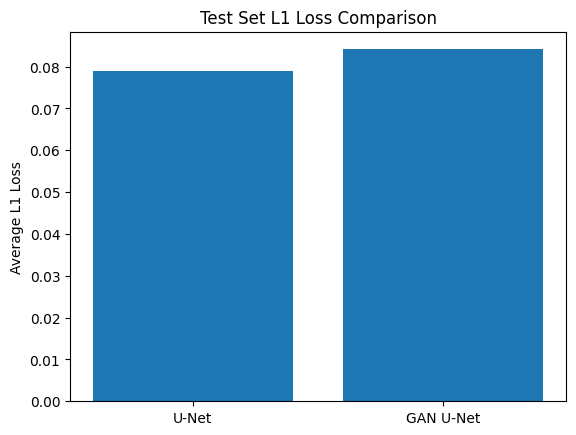

In [ ]:
import matplotlib.pyplot as plt

labels = ["U-Net", "GAN U-Net"]
losses = [unet_loss, gan_loss]

plt.bar(labels, losses)
plt.ylabel("Average L1 Loss")
plt.title("Test Set L1 Loss Comparison")
plt.show()


## STL10 (96x96)

Import dataset

In [8]:
class STL10ColorizationDataset(Dataset):
    def __init__(self, split="train"):
        stl_dataset = STL10(root="./data", split=split, download=True,
                            transform=transforms.Compose([
                                transforms.Resize((96, 96)),
                                transforms.ToTensor()
                            ]))

        self.data = []
        for img, _ in stl_dataset:
            img_np = img.permute(1, 2, 0).numpy()

            # Convert to LAB
            lab = rgb2lab(img_np).astype(np.float32)

            L = (lab[:, :, 0:1] / 50.0 - 1.0)
            ab = lab[:, :, 1:] / 110.0

            # Convert to tensors (C, H, W)
            lab_tensor = torch.from_numpy(np.concatenate([L, ab], axis=-1)).permute(2, 0, 1).float()
            l_tensor = lab_tensor[[0], ...]
            ab_tensor = lab_tensor[1:, ...]

            self.data.append((l_tensor, ab_tensor))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# Load the dataset
train_dataset = STL10ColorizationDataset(split="train")
test_dataset = STL10ColorizationDataset(split="test")

# DataLoader
dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, prefetch_factor=2, pin_memory=True)

100%|██████████| 2.64G/2.64G [16:54<00:00, 2.60MB/s]


Deeper discriminator since STL10 images are larger

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c=3, num_filters=64):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, k=4, s=2, p=1, norm=False)]   # 96 -> 48
        model += [self.get_layers(num_filters, num_filters * 2, k=4, s=2, p=1)]      # 48 -> 24
        model += [self.get_layers(num_filters * 2, num_filters * 4, k=4, s=2, p=1)]  # 24 -> 12
        model += [self.get_layers(num_filters * 4, num_filters * 8, k=4, s=2, p=1)]  # 12 -> 6
        model += [self.get_layers(num_filters * 8, 1, k=4, s=1, p=1, norm=False, act=False)]  # 6 -> 5
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, inplace=True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

### Using pretrained CIFAR10 encoder

Run same experiment as previous section, but using an encoder pretrained on **CIFAR10** (32x32) with **STL10** (96x96)

In [ ]:
body = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
body = nn.Sequential(*list(body.children())[:-2])
body[0] = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)

net_G = DynamicUnet(body, n_out=2, img_size=(96, 96))

net_G = net_G.to(device)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [ ]:
criterion = nn.L1Loss() # Use L1 loss to minimize color differences
opt = optim.Adam(net_G.parameters(), lr=1e-4)

losses_cifar10_unet = train_generator(net_G, dataloader, opt, criterion, num_epochs=30)
torch.save(net_G.state_dict(), "stl10-cifar-unet.pt")

Epoch [1/30]: 100%|██████████| 313/313 [00:17<00:00, 17.97it/s, loss=0.0816]


Epoch 1: Avg Loss = 0.0703


Epoch [2/30]: 100%|██████████| 313/313 [00:17<00:00, 17.63it/s, loss=0.0602]


Epoch 2: Avg Loss = 0.0698


Epoch [3/30]: 100%|██████████| 313/313 [00:17<00:00, 17.71it/s, loss=0.0885]


Epoch 3: Avg Loss = 0.0695


Epoch [4/30]: 100%|██████████| 313/313 [00:17<00:00, 18.02it/s, loss=0.0761]


Epoch 4: Avg Loss = 0.0690


Epoch [5/30]: 100%|██████████| 313/313 [00:17<00:00, 17.90it/s, loss=0.0577]


Epoch 5: Avg Loss = 0.0683


Epoch [6/30]: 100%|██████████| 313/313 [00:17<00:00, 18.04it/s, loss=0.0739]


Epoch 6: Avg Loss = 0.0682


Epoch [7/30]: 100%|██████████| 313/313 [00:17<00:00, 17.76it/s, loss=0.0917]


Epoch 7: Avg Loss = 0.0674


Epoch [8/30]: 100%|██████████| 313/313 [00:17<00:00, 17.62it/s, loss=0.0693]


Epoch 8: Avg Loss = 0.0670


Epoch [9/30]: 100%|██████████| 313/313 [00:17<00:00, 17.77it/s, loss=0.0642]


Epoch 9: Avg Loss = 0.0661


Epoch [10/30]: 100%|██████████| 313/313 [00:17<00:00, 17.85it/s, loss=0.0611]


Epoch 10: Avg Loss = 0.0657


Epoch [11/30]: 100%|██████████| 313/313 [00:17<00:00, 17.99it/s, loss=0.0546]


Epoch 11: Avg Loss = 0.0652


Epoch [12/30]: 100%|██████████| 313/313 [00:17<00:00, 17.83it/s, loss=0.0846]


Epoch 12: Avg Loss = 0.0648


Epoch [13/30]: 100%|██████████| 313/313 [00:17<00:00, 17.41it/s, loss=0.0715]


Epoch 13: Avg Loss = 0.0640


Epoch [14/30]: 100%|██████████| 313/313 [00:17<00:00, 17.86it/s, loss=0.0641]


Epoch 14: Avg Loss = 0.0634


Epoch [15/30]: 100%|██████████| 313/313 [00:17<00:00, 17.70it/s, loss=0.116]


Epoch 15: Avg Loss = 0.0631


Epoch [16/30]: 100%|██████████| 313/313 [00:17<00:00, 17.99it/s, loss=0.0645]


Epoch 16: Avg Loss = 0.0623


Epoch [17/30]: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s, loss=0.0653]


Epoch 17: Avg Loss = 0.0622


Epoch [18/30]: 100%|██████████| 313/313 [00:17<00:00, 17.50it/s, loss=0.0586]


Epoch 18: Avg Loss = 0.0617


Epoch [19/30]: 100%|██████████| 313/313 [00:17<00:00, 17.51it/s, loss=0.0599]


Epoch 19: Avg Loss = 0.0613


Epoch [20/30]: 100%|██████████| 313/313 [00:17<00:00, 17.89it/s, loss=0.054]


Epoch 20: Avg Loss = 0.0611


Epoch [21/30]: 100%|██████████| 313/313 [00:18<00:00, 17.16it/s, loss=0.0662]


Epoch 21: Avg Loss = 0.0609


Epoch [22/30]: 100%|██████████| 313/313 [00:19<00:00, 15.97it/s, loss=0.0573]


Epoch 22: Avg Loss = 0.0603


Epoch [23/30]: 100%|██████████| 313/313 [00:17<00:00, 17.88it/s, loss=0.0718]


Epoch 23: Avg Loss = 0.0600


Epoch [24/30]: 100%|██████████| 313/313 [00:17<00:00, 17.76it/s, loss=0.0494]


Epoch 24: Avg Loss = 0.0598


Epoch [25/30]: 100%|██████████| 313/313 [00:17<00:00, 17.90it/s, loss=0.0533]


Epoch 25: Avg Loss = 0.0595


Epoch [26/30]: 100%|██████████| 313/313 [00:17<00:00, 17.58it/s, loss=0.0547]


Epoch 26: Avg Loss = 0.0590


Epoch [27/30]: 100%|██████████| 313/313 [00:18<00:00, 16.71it/s, loss=0.059]


Epoch 27: Avg Loss = 0.0588


Epoch [28/30]: 100%|██████████| 313/313 [00:18<00:00, 17.29it/s, loss=0.0847]


Epoch 28: Avg Loss = 0.0585


Epoch [29/30]: 100%|██████████| 313/313 [00:19<00:00, 16.36it/s, loss=0.0535]


Epoch 29: Avg Loss = 0.0582


Epoch [30/30]: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s, loss=0.0554]

Epoch 30: Avg Loss = 0.0580


Visualize

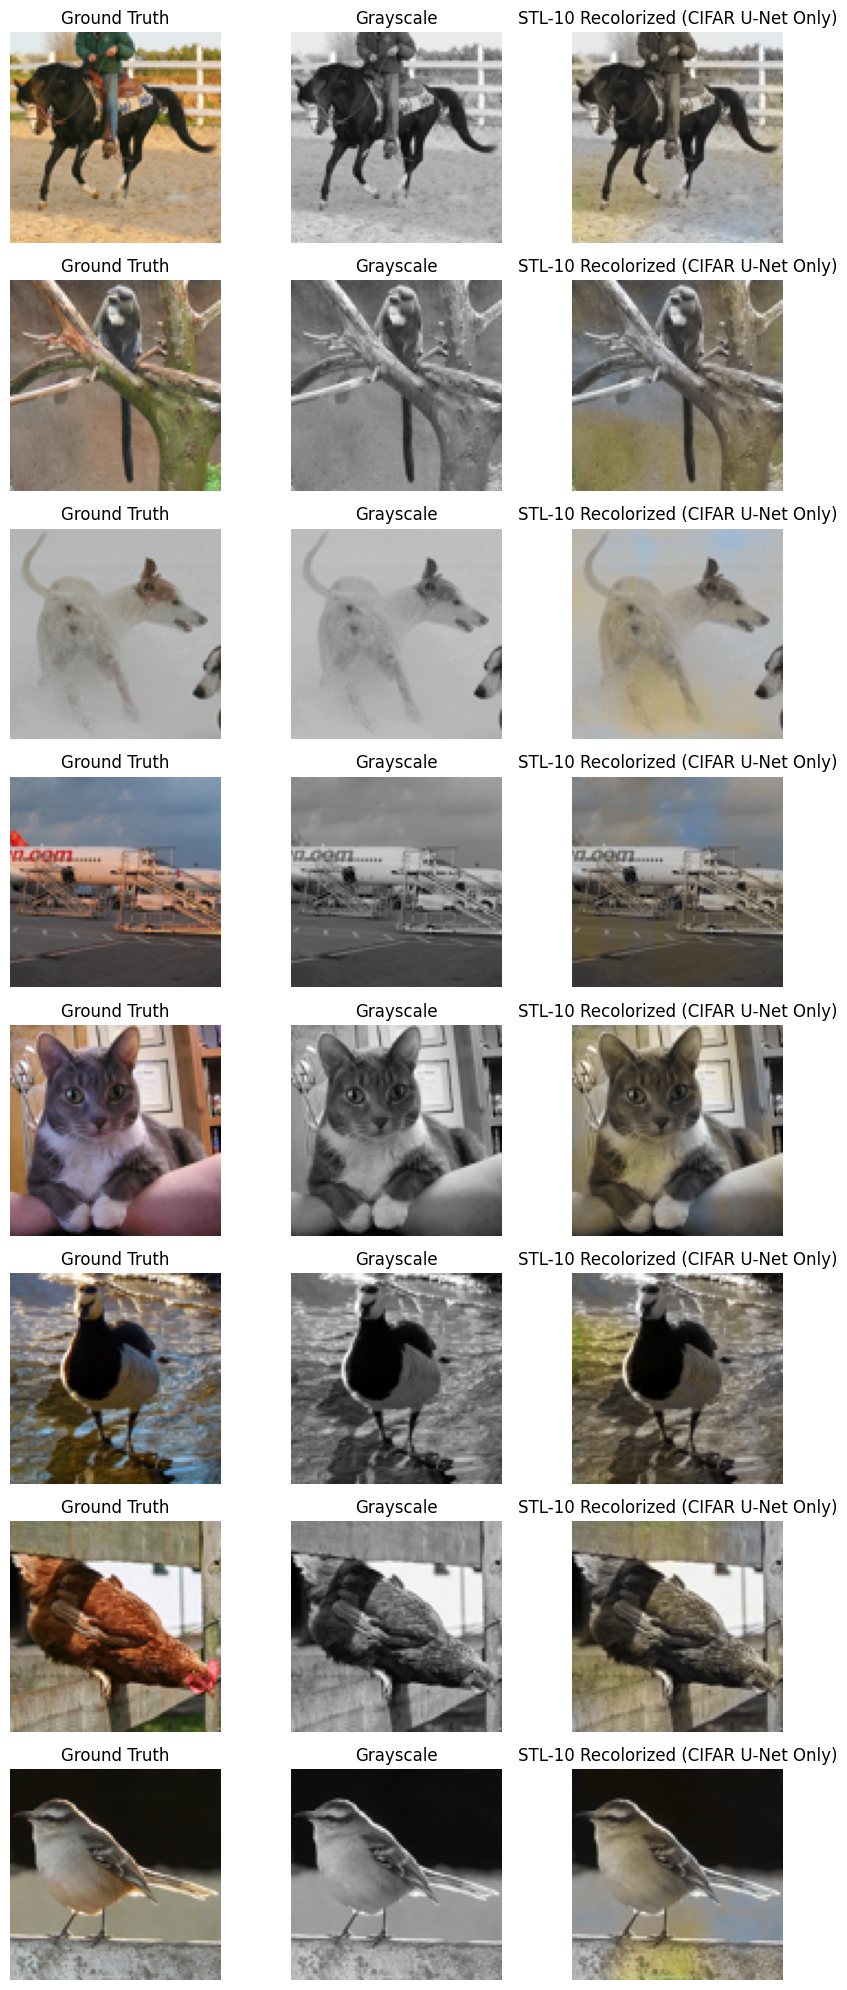

In [ ]:
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

def lab_to_rgb(L_tensor, ab_tensor):
    L = (L_tensor.squeeze(0).cpu().numpy() + 1.0) * 50.0
    ab = (ab_tensor.cpu().numpy() * 110.0)

    lab = np.concatenate([L[np.newaxis, :, :], ab], axis=0).transpose(1, 2, 0)

    rgb = lab2rgb(lab)

    rgb_uint8 = (rgb * 255).astype(np.uint8)
    return rgb_uint8

def l_to_gray_rgb(L_tensor):
    L_unscaled = (L_tensor.squeeze(0).cpu().numpy() + 1.0) * 50.0
    gray_normalized = L_unscaled / 100.0
    gray_uint8 = (gray_normalized * 255).astype(np.uint8)
    gray_rgb = cv2.cvtColor(gray_uint8, cv2.COLOR_GRAY2RGB)
    return gray_rgb

n = 8
fig, axs = plt.subplots(n, 3, figsize=(9, 2.5 * n))

for i in range(n):
    L, ab_gt = test_dataset[i]
    L_input = L.unsqueeze(0).to(device)

    with torch.no_grad():
        ab_pred = net_G(L_input).squeeze(0).cpu()

    ab_pred = torch.clamp(ab_pred, -1.0, 1.0)

    gt_rgb = lab_to_rgb(L, ab_gt)
    pred_rgb = lab_to_rgb(L, ab_pred)
    gray_rgb = l_to_gray_rgb(L)

    axs[i, 0].imshow(gt_rgb)
    axs[i, 0].set_title("Ground Truth")

    axs[i, 1].imshow(gray_rgb)
    axs[i, 1].set_title("Grayscale")

    axs[i, 2].imshow(pred_rgb)
    axs[i, 2].set_title("STL-10 Recolorized (CIFAR Encoder U-Net Only)")

    for j in range(3):
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

Train with GAN

In [ ]:
G = net_G
D = PatchDiscriminator(input_c=3).to(device)

In [ ]:
num_epochs = 40

opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()
lambda_L1 = 100

for epoch in range(num_epochs):
    for L, ab in dataloader:
        L, ab = L.to(device), ab.to(device)
        real_input = torch.cat([L, ab], dim=1)

        # 1. Train Discriminator
        with torch.no_grad():
            fake_ab = G(L)
        fake_input = torch.cat([L, fake_ab], dim=1)

        D_real = D(real_input)
        D_fake = D(fake_input)

        valid = torch.ones_like(D_real)
        fake = torch.zeros_like(D_fake)

        loss_D = 0.5 * (criterion_GAN(D_real, valid) + criterion_GAN(D_fake, fake))

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # 2. Train Generator
        fake_ab = G(L)
        fake_input = torch.cat([L, fake_ab], dim=1)
        D_fake_for_G = D(fake_input)

        loss_G_GAN = criterion_GAN(D_fake_for_G, valid)
        loss_G_L1 = criterion_L1(fake_ab, ab)
        loss_G = loss_G_GAN + lambda_L1 * loss_G_L1

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    if (epoch + 1) % 20 == 0:
      torch.save(G.state_dict(), f"G_epoch{epoch+1}_stl10_cifar10encoder_gan.pt")

    print(f"Epoch {epoch+1}: D = {loss_D.item():.3f}, G = {loss_G.item():.3f}, L1 = {loss_G_L1.item():.3f}")

Epoch 1: D = 0.750, G = 7.261, L1 = 0.069
Epoch 2: D = 0.580, G = 8.851, L1 = 0.081
Epoch 3: D = 0.530, G = 8.786, L1 = 0.073
Epoch 4: D = 0.823, G = 6.713, L1 = 0.064
Epoch 5: D = 0.255, G = 9.139, L1 = 0.072
Epoch 6: D = 0.482, G = 8.951, L1 = 0.080
Epoch 7: D = 0.552, G = 7.830, L1 = 0.068
Epoch 8: D = 0.287, G = 12.943, L1 = 0.103
Epoch 9: D = 1.010, G = 8.681, L1 = 0.078
Epoch 10: D = 0.629, G = 7.769, L1 = 0.072
Epoch 11: D = 0.488, G = 9.726, L1 = 0.077
Epoch 12: D = 1.617, G = 7.794, L1 = 0.070
Epoch 13: D = 0.263, G = 9.536, L1 = 0.078
Epoch 14: D = 0.297, G = 9.926, L1 = 0.082
Epoch 15: D = 0.842, G = 8.565, L1 = 0.079
Epoch 16: D = 0.962, G = 8.252, L1 = 0.071
Epoch 17: D = 0.203, G = 10.829, L1 = 0.084
Epoch 18: D = 0.562, G = 8.918, L1 = 0.078
Epoch 19: D = 0.511, G = 7.086, L1 = 0.064
Epoch 20: D = 0.353, G = 10.813, L1 = 0.084
Epoch 21: D = 0.316, G = 10.896, L1 = 0.081
Epoch 22: D = 0.339, G = 8.081, L1 = 0.058
Epoch 23: D = 0.605, G = 7.515, L1 = 0.066
Epoch 24: D = 0.

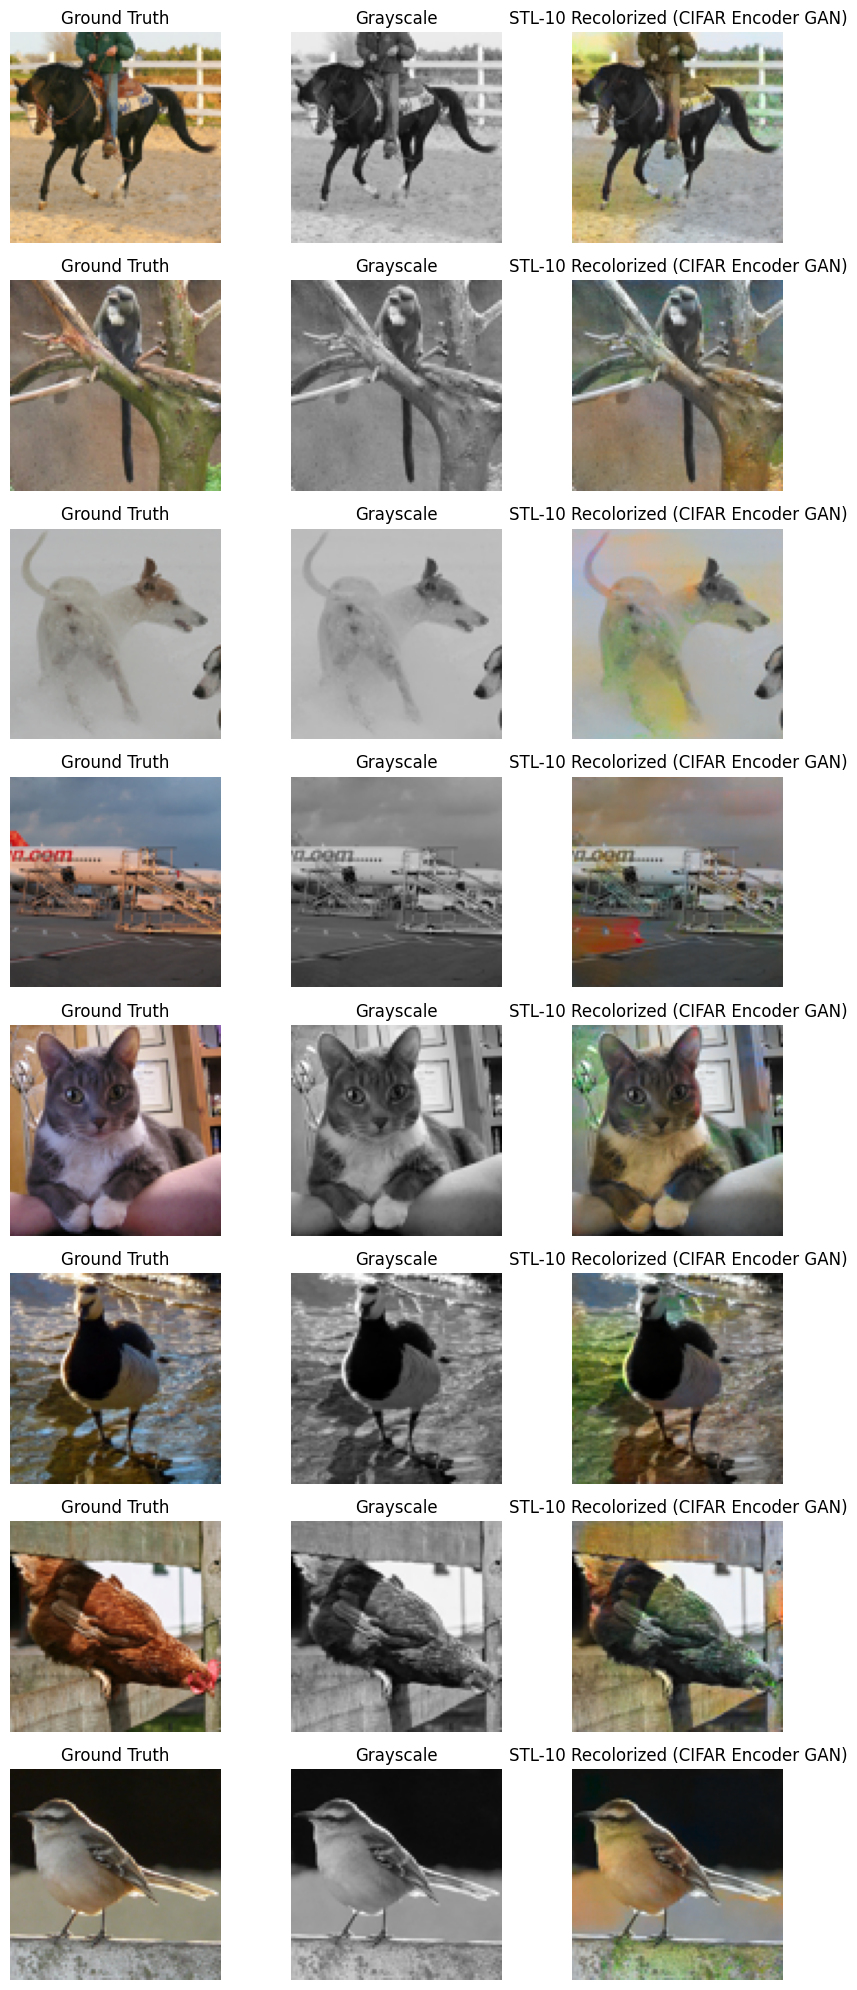

In [ ]:
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

def lab_to_rgb(L_tensor, ab_tensor):
    L = (L_tensor.squeeze(0).cpu().numpy() + 1.0) * 50.0  # L in [0, 100]
    ab = (ab_tensor.cpu().numpy() * 110.0)                # ab in [-128, 127]

    lab = np.concatenate([L[np.newaxis, :, :], ab], axis=0).transpose(1, 2, 0)  # (H, W, 3)

    rgb = lab2rgb(lab)

    rgb_uint8 = (rgb * 255).astype(np.uint8)
    return rgb_uint8

def l_to_gray_rgb(L_tensor):
    L_unscaled = (L_tensor.squeeze(0).cpu().numpy() + 1.0) * 50.0
    gray_normalized = L_unscaled / 100.0
    gray_uint8 = (gray_normalized * 255).astype(np.uint8)
    gray_rgb = cv2.cvtColor(gray_uint8, cv2.COLOR_GRAY2RGB)
    return gray_rgb

n = 8
fig, axs = plt.subplots(n, 3, figsize=(9, 2.5 * n))

for i in range(n):
    L, ab_gt = test_dataset[i]
    L_input = L.unsqueeze(0).to(device)

    with torch.no_grad():
        ab_pred = net_G(L_input).squeeze(0).cpu()

    ab_pred = torch.clamp(ab_pred, -1.0, 1.0)

    gt_rgb = lab_to_rgb(L, ab_gt)
    pred_rgb = lab_to_rgb(L, ab_pred)
    gray_rgb = l_to_gray_rgb(L)

    axs[i, 0].imshow(gt_rgb)
    axs[i, 0].set_title("Ground Truth")

    axs[i, 1].imshow(gray_rgb)
    axs[i, 1].set_title("Grayscale")

    axs[i, 2].imshow(pred_rgb)
    axs[i, 2].set_title("STL-10 Recolorized (CIFAR Encoder GAN)")

    for j in range(3):
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

### Using pretrained Imagenet encoder

Now using an encoder pretrained on **ImageNet** (average 469x387)

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

resnet18_model = resnet18(weights="IMAGENET1K_V1")

body = create_body(resnet18_model, n_in=1, cut=-2)

net_G = DynamicUnet(body, 2, (96, 96)).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


In [ ]:
criterion = nn.L1Loss()
opt = optim.Adam(net_G.parameters(), lr=1e-4)

losses_imagenet = train_generator(net_G, dataloader, opt, criterion, num_epochs=30)
torch.save(net_G.state_dict(), "stl10-imagenet-unet.pt")

Epoch [1/30]: 100%|██████████| 313/313 [00:34<00:00,  9.06it/s, loss=0.0671]


Epoch 1: Avg Loss = 0.0830


Epoch [2/30]: 100%|██████████| 313/313 [00:32<00:00,  9.52it/s, loss=0.0648]


Epoch 2: Avg Loss = 0.0712


Epoch [3/30]: 100%|██████████| 313/313 [00:33<00:00,  9.39it/s, loss=0.0529]


Epoch 3: Avg Loss = 0.0681


Epoch [4/30]: 100%|██████████| 313/313 [00:33<00:00,  9.31it/s, loss=0.0772]


Epoch 4: Avg Loss = 0.0656


Epoch [5/30]: 100%|██████████| 313/313 [00:33<00:00,  9.24it/s, loss=0.0615]


Epoch 5: Avg Loss = 0.0637


Epoch [6/30]: 100%|██████████| 313/313 [00:34<00:00,  9.18it/s, loss=0.0757]


Epoch 6: Avg Loss = 0.0615


Epoch [7/30]: 100%|██████████| 313/313 [00:34<00:00,  9.11it/s, loss=0.0751]


Epoch 7: Avg Loss = 0.0597


Epoch [8/30]: 100%|██████████| 313/313 [00:34<00:00,  9.09it/s, loss=0.0846]


Epoch 8: Avg Loss = 0.0581


Epoch [9/30]: 100%|██████████| 313/313 [00:34<00:00,  9.06it/s, loss=0.0692]


Epoch 9: Avg Loss = 0.0567


Epoch [10/30]: 100%|██████████| 313/313 [00:34<00:00,  9.04it/s, loss=0.0416]


Epoch 10: Avg Loss = 0.0556


Epoch [11/30]: 100%|██████████| 313/313 [00:34<00:00,  9.03it/s, loss=0.0584]


Epoch 11: Avg Loss = 0.0534


Epoch [12/30]: 100%|██████████| 313/313 [00:34<00:00,  9.01it/s, loss=0.0477]


Epoch 12: Avg Loss = 0.0520


Epoch [13/30]: 100%|██████████| 313/313 [00:34<00:00,  8.99it/s, loss=0.0502]


Epoch 13: Avg Loss = 0.0508


Epoch [14/30]: 100%|██████████| 313/313 [00:34<00:00,  9.01it/s, loss=0.0465]


Epoch 14: Avg Loss = 0.0490


Epoch [15/30]: 100%|██████████| 313/313 [00:34<00:00,  9.01it/s, loss=0.0492]


Epoch 15: Avg Loss = 0.0480


Epoch [16/30]: 100%|██████████| 313/313 [00:34<00:00,  8.99it/s, loss=0.0431]


Epoch 16: Avg Loss = 0.0472


Epoch [17/30]: 100%|██████████| 313/313 [00:34<00:00,  9.00it/s, loss=0.0578]


Epoch 17: Avg Loss = 0.0457


Epoch [18/30]: 100%|██████████| 313/313 [00:34<00:00,  9.01it/s, loss=0.0416]


Epoch 18: Avg Loss = 0.0444


Epoch [19/30]: 100%|██████████| 313/313 [00:34<00:00,  8.97it/s, loss=0.0499]


Epoch 19: Avg Loss = 0.0434


Epoch [20/30]: 100%|██████████| 313/313 [00:34<00:00,  8.98it/s, loss=0.0448]


Epoch 20: Avg Loss = 0.0424


Epoch [21/30]: 100%|██████████| 313/313 [00:34<00:00,  8.96it/s, loss=0.0462]


Epoch 21: Avg Loss = 0.0412


Epoch [22/30]: 100%|██████████| 313/313 [00:34<00:00,  8.98it/s, loss=0.0354]


Epoch 22: Avg Loss = 0.0402


Epoch [23/30]: 100%|██████████| 313/313 [00:34<00:00,  8.99it/s, loss=0.0306]


Epoch 23: Avg Loss = 0.0394


Epoch [24/30]: 100%|██████████| 313/313 [00:34<00:00,  8.94it/s, loss=0.0452]


Epoch 24: Avg Loss = 0.0386


Epoch [25/30]: 100%|██████████| 313/313 [00:36<00:00,  8.65it/s, loss=0.0292]


Epoch 25: Avg Loss = 0.0377


Epoch [26/30]: 100%|██████████| 313/313 [00:35<00:00,  8.72it/s, loss=0.0498]


Epoch 26: Avg Loss = 0.0370


Epoch [27/30]: 100%|██████████| 313/313 [00:38<00:00,  8.23it/s, loss=0.0364]


Epoch 27: Avg Loss = 0.0365


Epoch [28/30]: 100%|██████████| 313/313 [00:36<00:00,  8.59it/s, loss=0.0321]


Epoch 28: Avg Loss = 0.0358


Epoch [29/30]: 100%|██████████| 313/313 [00:35<00:00,  8.69it/s, loss=0.0276]


Epoch 29: Avg Loss = 0.0350


Epoch [30/30]: 100%|██████████| 313/313 [00:35<00:00,  8.86it/s, loss=0.0356]


Epoch 30: Avg Loss = 0.0343


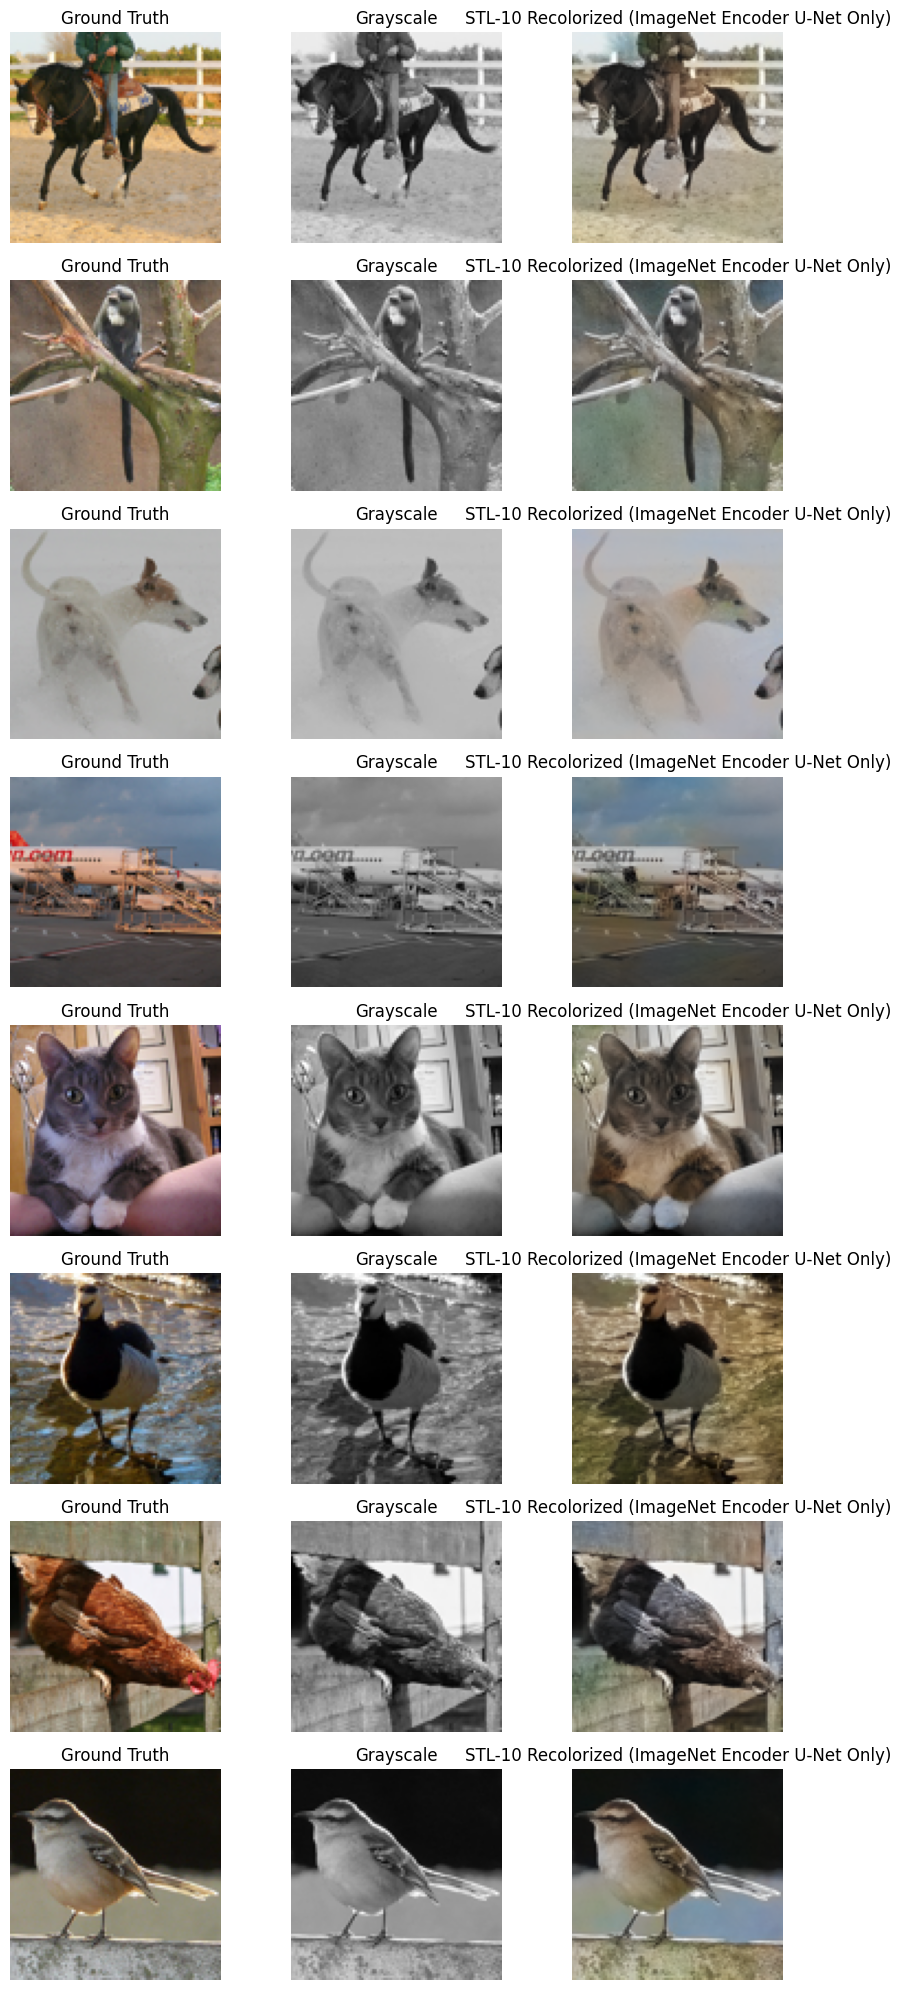

In [ ]:
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

def lab_to_rgb(L_tensor, ab_tensor):
    L = (L_tensor.squeeze(0).cpu().numpy() + 1.0) * 50.0
    ab = (ab_tensor.cpu().numpy() * 110.0)

    lab = np.concatenate([L[np.newaxis, :, :], ab], axis=0).transpose(1, 2, 0)  # (H, W, 3)

    rgb = lab2rgb(lab)

    rgb_uint8 = (rgb * 255).astype(np.uint8)
    return rgb_uint8

def l_to_gray_rgb(L_tensor):
    L_unscaled = (L_tensor.squeeze(0).cpu().numpy() + 1.0) * 50.0
    gray_normalized = L_unscaled / 100.0
    gray_uint8 = (gray_normalized * 255).astype(np.uint8)
    gray_rgb = cv2.cvtColor(gray_uint8, cv2.COLOR_GRAY2RGB)
    return gray_rgb

n = 8
fig, axs = plt.subplots(n, 3, figsize=(9, 2.5 * n))

for i in range(n):
    L, ab_gt = test_dataset[i]
    L_input = L.unsqueeze(0).to(device)

    with torch.no_grad():
        ab_pred = net_G(L_input).squeeze(0).cpu()

    ab_pred = torch.clamp(ab_pred, -1.0, 1.0)

    gt_rgb = lab_to_rgb(L, ab_gt)
    pred_rgb = lab_to_rgb(L, ab_pred)
    gray_rgb = l_to_gray_rgb(L)

    axs[i, 0].imshow(gt_rgb)
    axs[i, 0].set_title("Ground Truth")

    axs[i, 1].imshow(gray_rgb)
    axs[i, 1].set_title("Grayscale")

    axs[i, 2].imshow(pred_rgb)
    axs[i, 2].set_title("STL-10 Recolorized (ImageNet Encoder U-Net Only)")

    for j in range(3):
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

Train with GAN

In [ ]:
G = net_G
D = PatchDiscriminator(input_c=3).to(device)

In [ ]:
num_epochs = 40

opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()
lambda_L1 = 100

for epoch in range(num_epochs):
    for L, ab in dataloader:
        L, ab = L.to(device), ab.to(device)
        real_input = torch.cat([L, ab], dim=1)

        # 1. Train Discriminator
        with torch.no_grad():
            fake_ab = G(L)
        fake_input = torch.cat([L, fake_ab], dim=1)

        D_real = D(real_input)
        D_fake = D(fake_input)

        valid = torch.ones_like(D_real)
        fake = torch.zeros_like(D_fake)

        loss_D = 0.5 * (criterion_GAN(D_real, valid) + criterion_GAN(D_fake, fake))

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # 2. Train Generator
        fake_ab = G(L)
        fake_input = torch.cat([L, fake_ab], dim=1)
        D_fake_for_G = D(fake_input)

        loss_G_GAN = criterion_GAN(D_fake_for_G, valid)
        loss_G_L1 = criterion_L1(fake_ab, ab)
        loss_G = loss_G_GAN + lambda_L1 * loss_G_L1

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    if (epoch + 1) % 20 == 0:
      torch.save(G.state_dict(), f"G_epoch{epoch+1}_stl10_imagenet_encoder_gan.pt")

    print(f"Epoch {epoch+1}: D = {loss_D.item():.3f}, G = {loss_G.item():.3f}, L1 = {loss_G_L1.item():.3f}")

Epoch 1: D = 0.448, G = 5.388, L1 = 0.044
Epoch 2: D = 0.723, G = 5.009, L1 = 0.043
Epoch 3: D = 0.572, G = 4.579, L1 = 0.038
Epoch 4: D = 0.540, G = 5.644, L1 = 0.046
Epoch 5: D = 0.716, G = 4.536, L1 = 0.038
Epoch 6: D = 0.972, G = 4.732, L1 = 0.040
Epoch 7: D = 0.692, G = 5.094, L1 = 0.042
Epoch 8: D = 0.706, G = 5.069, L1 = 0.042
Epoch 9: D = 0.605, G = 4.383, L1 = 0.037
Epoch 10: D = 0.608, G = 5.081, L1 = 0.042
Epoch 11: D = 0.790, G = 4.349, L1 = 0.035
Epoch 12: D = 0.705, G = 4.414, L1 = 0.037
Epoch 13: D = 0.691, G = 5.847, L1 = 0.045
Epoch 14: D = 0.739, G = 5.680, L1 = 0.042
Epoch 15: D = 0.620, G = 4.205, L1 = 0.034
Epoch 16: D = 0.726, G = 4.706, L1 = 0.038
Epoch 17: D = 0.655, G = 3.851, L1 = 0.032
Epoch 18: D = 0.605, G = 5.568, L1 = 0.038
Epoch 19: D = 0.562, G = 5.082, L1 = 0.039
Epoch 20: D = 0.576, G = 4.920, L1 = 0.042
Epoch 21: D = 0.302, G = 6.682, L1 = 0.045
Epoch 22: D = 0.521, G = 4.803, L1 = 0.036
Epoch 23: D = 0.586, G = 5.324, L1 = 0.034
Epoch 24: D = 0.578,

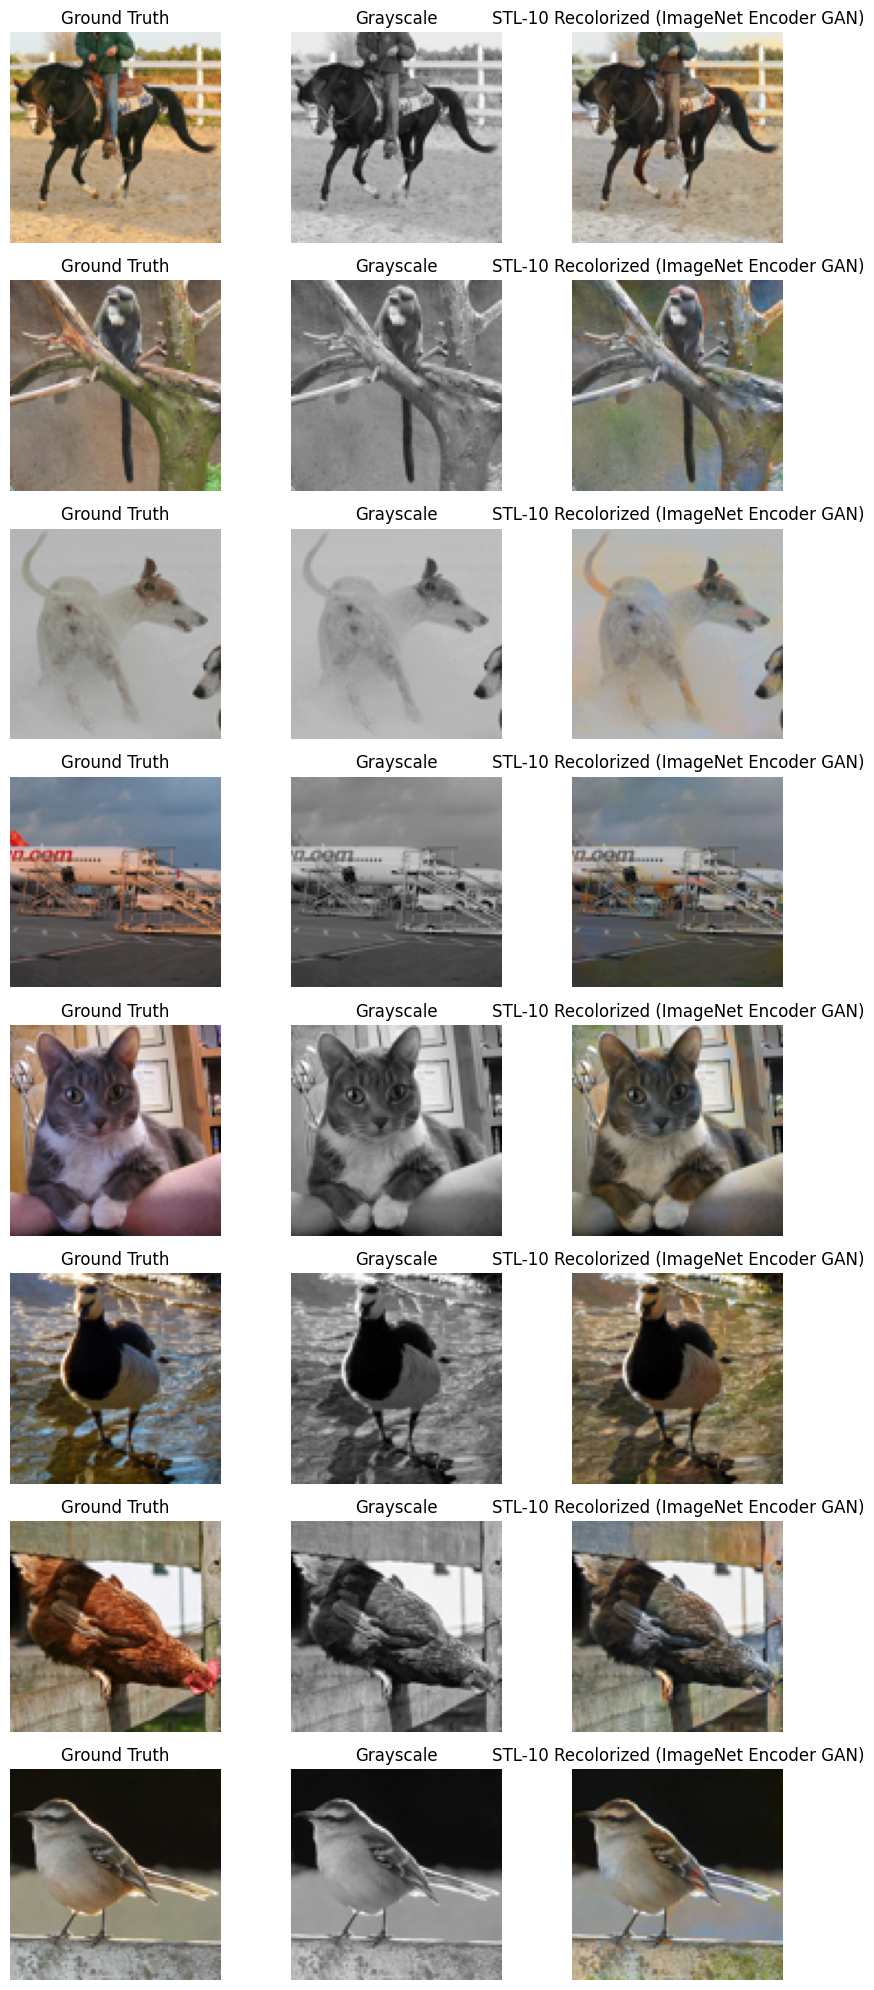

In [ ]:
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

def lab_to_rgb(L_tensor, ab_tensor):
    L = (L_tensor.squeeze(0).cpu().numpy() + 1.0) * 50.0
    ab = (ab_tensor.cpu().numpy() * 110.0)

    lab = np.concatenate([L[np.newaxis, :, :], ab], axis=0).transpose(1, 2, 0)  # (H, W, 3)

    rgb = lab2rgb(lab)

    rgb_uint8 = (rgb * 255).astype(np.uint8)
    return rgb_uint8

def l_to_gray_rgb(L_tensor):
    L_unscaled = (L_tensor.squeeze(0).cpu().numpy() + 1.0) * 50.0
    gray_normalized = L_unscaled / 100.0
    gray_uint8 = (gray_normalized * 255).astype(np.uint8)
    gray_rgb = cv2.cvtColor(gray_uint8, cv2.COLOR_GRAY2RGB)
    return gray_rgb

n = 8
fig, axs = plt.subplots(n, 3, figsize=(9, 2.5 * n))

for i in range(n):
    L, ab_gt = test_dataset[i]
    L_input = L.unsqueeze(0).to(device)

    with torch.no_grad():
        ab_pred = net_G(L_input).squeeze(0).cpu()

    ab_pred = torch.clamp(ab_pred, -1.0, 1.0)

    gt_rgb = lab_to_rgb(L, ab_gt)
    pred_rgb = lab_to_rgb(L, ab_pred)
    gray_rgb = l_to_gray_rgb(L)

    axs[i, 0].imshow(gt_rgb)
    axs[i, 0].set_title("Ground Truth")

    axs[i, 1].imshow(gray_rgb)
    axs[i, 1].set_title("Grayscale")

    axs[i, 2].imshow(pred_rgb)
    axs[i, 2].set_title("STL-10 Recolorized (ImageNet Encoder U-Net Only)")

    for j in range(3):
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

Compare the two different encoders

In [11]:
# Load u-net trained generator
body = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
body = nn.Sequential(*list(body.children())[:-2])
body[0] = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)

cifar10_encoder_gen = DynamicUnet(body, n_out=2, img_size=(96, 96))

cifar10_encoder_gen = cifar10_encoder_gen.to(device)

cifar10_encoder_gen.load_state_dict(torch.load("G_epoch40_stl10_cifar10encoder_gan.pt", map_location=device))
cifar10_encoder_gen.eval()

resnet18_model = resnet18(weights="IMAGENET1K_V1")

body = create_body(resnet18_model, n_in=1, cut=-2)

imagenet_encoder_gen = DynamicUnet(body, 2, (96, 96)).to(device)
imagenet_encoder_gen.load_state_dict(torch.load("G_epoch40_stl10_imagenet_encoder_gan.pt", map_location=device))
imagenet_encoder_gen.eval()

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 241MB/s]


DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [12]:
l1_loss_fn = nn.L1Loss()

def evaluate_model_l1(model, data_loader):
    model.eval()
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for L, ab_gt in data_loader:
            L, ab_gt = L.to(device), ab_gt.to(device)
            ab_pred = model(L)

            loss = l1_loss_fn(ab_pred, ab_gt)
            total_loss += loss.item() * L.size(0)
            count += L.size(0)

    return total_loss / count


cifar10_encoder_loss = evaluate_model_l1(cifar10_encoder_gen, test_loader)
imagenet_encoder_loss = evaluate_model_l1(imagenet_encoder_gen, test_loader)
print(f"CIFAR10 Encoder L1 Loss: {cifar10_encoder_loss:.4f}")
print(f"ImageNet Encoder L1 Loss: {imagenet_encoder_loss:.4f}")

CIFAR10 Encoder L1 Loss: 0.0861
ImageNet Encoder L1 Loss: 0.0761


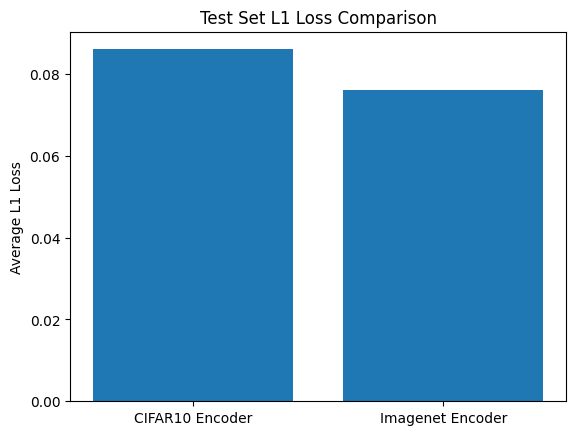

In [13]:
import matplotlib.pyplot as plt

labels = ["CIFAR10 Encoder", "ImageNet Encoder"]
losses = [cifar10_encoder_loss, imagenet_encoder_loss]

plt.bar(labels, losses)
plt.ylabel("Average L1 Loss")
plt.title("Test Set L1 Loss Comparison")
plt.show()
